In [1]:
import os 
import sys
sys.path.append('/home/zbohan/projects/')
#sys.path.append('/home/kalkiek/projects/reddit-political-affiliation/')

import itertools
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm.notebook import tqdm
from collections import defaultdict,Counter
from sklearn.metrics import accuracy_score

from src.data.make_dataset import build_dataset
from src.models.word2vec.User2Subreddit import User2Subreddit

from sklearn.metrics import auc, roc_curve
import glob

In [2]:
import numpy as np

In [3]:
from src.data.SubredditUserDataset import SubredditUserDataset

In [4]:
year_month = '2019-04'
network_path = '/shared/0/projects/reddit-political-affiliation/data/bipartite-networks/' + year_month + '_filtered.tsv'
flair_directory = '/shared/0/projects/reddit-political-affiliation/data/flair-affiliations/' + year_month + '.tsv'
#flair_directory='/home/zbohan/projects/src/data/'+year_month+'.tsv'
flair_files = glob.glob(flair_directory)

In [5]:
def read_political_affiliations(files):
    user_to_politic_counts = defaultdict(Counter)

    for fname in tqdm(files):
        with open(fname, 'rt') as f:
            for line in f:
                user, politics, freq = line.split('\t')
                user_to_politic_counts[user][politics] += int(freq)

    print("User to politic counts: " + str(len(user_to_politic_counts)))
    print(list(user_to_politic_counts.items())[:10])

    user_to_politics = {}
    for u, pc in user_to_politic_counts.items():
        if len(pc) > 1:
            continue
        user_to_politics[u] = list(pc.keys())[0]

    print('Saw political affiliations for %d users' % len(user_to_politics))
    return convert_affiliations_to_binary(user_to_politics)


def convert_affiliations_to_binary(user_to_politics):
    for user, politics in user_to_politics.items():
        if politics == "Democrat":
            user_to_politics[user] = 0
        else:
            user_to_politics[user] = 1

    return user_to_politics

In [6]:
ground_pol=read_political_affiliations(flair_files)


User to politic counts: 2589
[('WatchMaga', Counter({'Republican': 2})), ('BasedMedicalDoctor', Counter({'Republican': 2})), ('Damemezaredadremez', Counter({'Republican': 2})), ('joeohegna', Counter({'Republican': 1})), ('Deplorable_scum', Counter({'Republican': 2})), ('TheRabbidHD', Counter({'Republican': 2})), ('Paladin-Arda', Counter({'Democrat': 2})), ('Trumpwillalwayswin', Counter({'Republican': 2})), ('daw-nee-yale', Counter({'Republican': 1})), ('BigcatTV', Counter({'Republican': 2}))]
Saw political affiliations for 2588 users


In [7]:
def build_user_to_subreddits(bipartite_network,pol):
    vocab = set()
    user_subreddits = defaultdict(dict)
    all_subreddits = Counter()

    with open(bipartite_network, 'rt') as f:
        lines = f.readlines()

    for line in tqdm(lines, position=1, desc='Building vocab from file'):
        user, subreddit, freq = line[:-1].split('\t')
        if user in pol:
            #print(user,subreddit,freq)
            vocab.add(user)
            vocab.add(subreddit)
            user_subreddits[user][subreddit]=int(freq)
            all_subreddits[subreddit]+=int(freq)

    all_subreddits = list(all_subreddits)
    print("Length of vocab: " + str(len(vocab)))
    print("User count: " + str(len(user_subreddits)))
    print("Subreddit count: " + str(len(all_subreddits)))
    return user_subreddits, vocab, all_subreddits

In [8]:
u,v,a=build_user_to_subreddits(network_path,ground_pol)


Length of vocab: 8966
User count: 2333
Subreddit count: 6633


In [9]:
dict_a=dict(zip(a,range(len(a))))

In [10]:
feat_matrix=np.zeros((len(u),len(dict_a)))
y=[]
for i,user in enumerate(u.keys()):
    y.append(ground_pol[user])
    for j,sub in enumerate(u[user].keys()):
        feat_matrix[i][dict_a[sub]]=u[user][sub]
y=np.array(y)

In [95]:
from sklearn.decomposition import PCA

In [97]:
pca = PCA(n_components=3)

In [100]:
decomp_feat = pca.fit_transform(feat_matrix) 

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


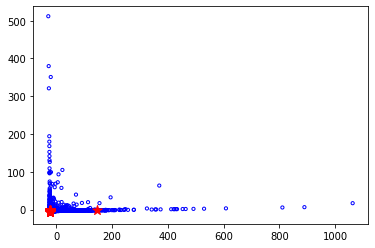

In [104]:
import matplotlib.pyplot as plt
plt.figure(0)
plt.scatter(decomp_feat[y==1,0],decomp_feat[y==1,1],color='', marker='o', edgecolors='blue', s=10)
plt.scatter(decomp_feat[y==0,0],decomp_feat[y==0,1],color='red',marker='*',s=100)
# plt.figure(1)
# plt.scatter(decomp_feat[y==1,0],decomp_feat[y==1,1],color='', marker='o', edgecolors='blue', s=10)
# plt.figure(2)
# plt.scatter(decomp_feat[y==0,0],decomp_feat[y==0,1],color='red',marker='*',s=100)
# plt.show()

In [102]:
from sklearn import manifold

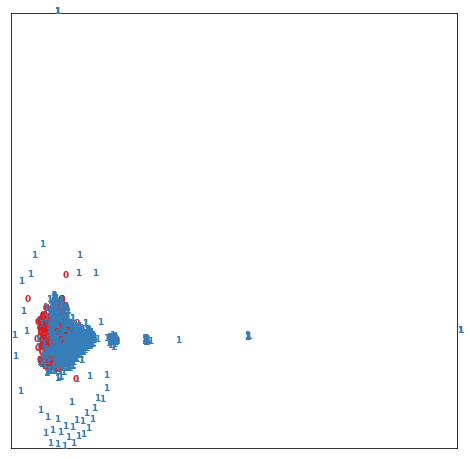

In [105]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501,n_jobs=4)
X_tsne = tsne.fit_transform(feat_matrix)


x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()